## Needed Imports

In [365]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn import linear_model, preprocessing
from sklearn import metrics as sm


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Data preperation

In [366]:
lines = []
with open('data/video_games.csv', 'r') as input:
    lines = input.readlines()

conversion = '"'
newtext = ''
outputLines = []
for line in lines:
    temp = line[:]
    for c in conversion:
        temp = temp.replace(c, newtext)
    outputLines.append(temp)

with open('data/video_games4.csv', 'w') as output:
    for line in outputLines:
        output.write(line)

In [367]:
df = pd.read_csv('data/video_games4.csv', index_col=False, encoding='iso-8859-1', nrows=1000,
                        warn_bad_lines=False, error_bad_lines=False)

In [368]:
def group_review_score():
    df['Metrics.Review Group'] = ''
    df.loc[df['Metrics.Review Score'] <= 25, 'Metrics.Review Group'] = 1
    df.loc[(df['Metrics.Review Score'] >= 26) & (df['Metrics.Review Score'] <=50), 'Metrics.Review Group'] = 2
    df.loc[(df['Metrics.Review Score'] >= 51) & (df['Metrics.Review Score'] <=75), 'Metrics.Review Group'] = 3
    df.loc[(df['Metrics.Review Score'] >= 76) & (df['Metrics.Review Score'] <=100), 'Metrics.Review Group'] = 4

In [400]:
# We had 167 nan values on the puplisher column, we will replace those with "Unknown" publishers. 
df['Metadata.Publishers'].fillna('Unkown', inplace = True)
## For prettier numbers, we'll turn the Sales from "in millions" to "in thousands".
df['Metrics.Sales']= df['Metrics.Sales']*1000

## Group the review scores into 4 classes for later confusion matrix
group_review_score()


In [370]:
df['Metrics.Review Group'].value_counts()

3    491
4    267
2     84
1      3
Name: Metrics.Review Group, dtype: int64

In [398]:
df.head()

,Title,Features.Handheld,Features.Max Players,Features.Multiplatform,Features.Online,Metadata.Genres,Metadata.Licensed,Metadata.Publishers,Metadata.Sequel,Metrics.Review Score,...,Length.Main + Extras.Leisure,Length.Main + Extras.Median,Length.Main + Extras.Polled,Length.Main + Extras.Rushed,Length.Main Story.Average,Length.Main Story.Leisure,Length.Main Story.Median,Length.Main Story.Polled,Length.Main Story.Rushed,Metrics.Review Group
0,Super Mario 64 DS,True,1,True,True,Action,True,Nintendo,True,85,...,29.966667,25.00,16,18.333333,14.333333,18.316667,14.5,21,9.700000,4
1,Lumines: Puzzle Fusion,True,1,True,True,Strategy,True,Ubisoft,True,89,...,9.866667,9.75,2,9.616667,10.333333,11.083333,10.0,3,9.583333,4
2,Hot Shots Golf: Open Tee,True,1,True,True,Sports,True,Sony,True,81,...,0.000000,0.00,0,0.000000,0.000000,0.000000,0.0,0,0.000000,4
3,Spider-Man 2,True,1,True,True,Action,True,Activision,True,61,...,17.316667,12.50,12,10.483333,8.350000,11.083333,8.0,23,5.333333,3
4,The Urbz: Sims in the City,True,1,True,True,Simulation,True,EA,True,67,...,25.200000,20.00,3,16.450000,15.500000,15.750000,15.5,2,15.250000,3


## Data Analysis

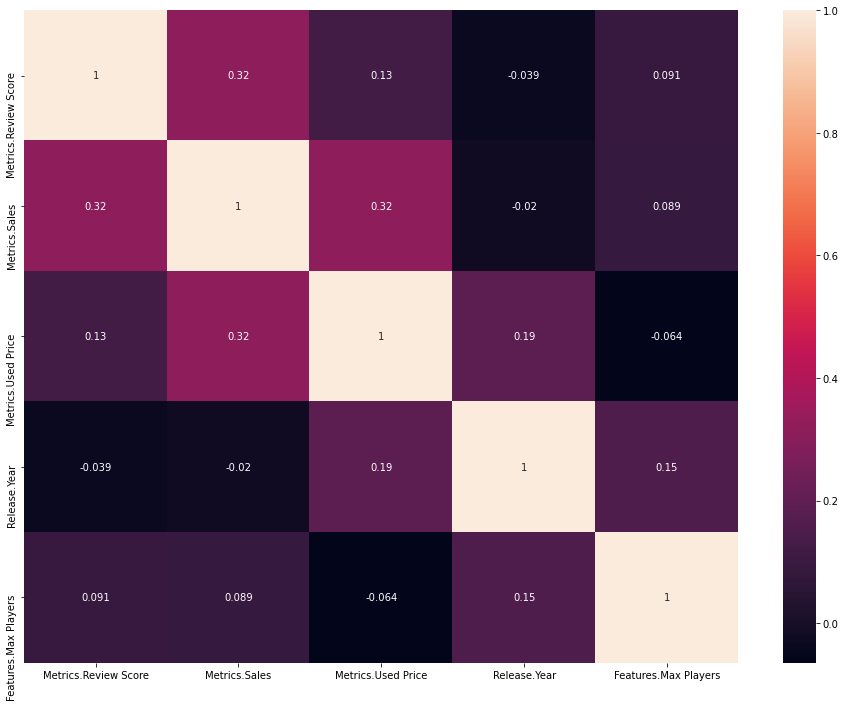

In [405]:
df_corr_1 = df.drop(['Features.Handheld', 'Features.Max Players', 'Features.Multiplatform', 'Features.Online', 'Metadata.Licensed',  'Metadata.Sequel', 'Release.Re-release'], 1)
df_corr = df[['Metrics.Review Score','Metrics.Sales', 'Metrics.Used Price', 'Release.Year', 'Features.Max Players',]]
corr_matrix = df_corr.corr()
plt.subplots(figsize = (16, 12))
sns.heatmap(corr_matrix, annot=True)

## Multiple Linear regression

In [372]:
def makeListForLabel(label_name):
    myList = df[label_name]
    tempArray = []
    for word in myList:
        if word not in tempArray:
            tempArray.append(word)
    return tempArray   

In [373]:

df_encoded = pd.DataFrame()

labels = {
    'Metadata.Genres': makeListForLabel('Metadata.Genres'),
    'Metadata.Publishers': makeListForLabel('Metadata.Publishers'),
    'Features.Handheld': makeListForLabel('Features.Handheld'),
    'Features.Multiplatform': makeListForLabel('Features.Multiplatform'),
    'Features.Online': makeListForLabel('Features.Online'),
    'Metadata.Licensed': makeListForLabel('Metadata.Licensed'),
    'Metadata.Sequel': makeListForLabel('Metadata.Sequel'),
    'Release.Console': makeListForLabel('Release.Console'),
    'Release.Rating': makeListForLabel('Release.Rating'),
    
}
label_encoders = {}
for column in df:
    if column in labels:
        label_encoders[column] = preprocessing.LabelEncoder()
        label_encoders[column].fit(labels[column])
        df_encoded[column] = label_encoders[column].transform(df[column])
    else:
        df_encoded[column] = df[column]      

In [374]:
Multi_features = np.array(df_encoded[[
    'Metrics.Review Score', 
    'Release.Year', 
    'Features.Max Players',
    'Metadata.Genres'  
     ]    
])
Multi_label = np.array(df_encoded['Metrics.Sales'])
Multi_regressor = linear_model.LinearRegression()

In [375]:
Multi_features_train, Multi_features_test, Multi_label_train, Multi_label_test = model_selection.train_test_split(Multi_features,Multi_label, test_size = 0.1)

In [376]:
Multi_regressor.fit(Multi_features_train,Multi_label_train)

LinearRegression()

In [377]:
Multi_label_prediction = Multi_regressor.predict(Multi_features_test)

### Prediction

In [378]:
newData = np.array([85, 2020, 1, 1]).reshape(1,-1)
Multi_regressor.predict(newData)

array([539.45155205])

## Validation of Multiple Variable regression

In [379]:
# The mean squared error
print("Mean squared error: %.2f" % sm.mean_squared_error(Multi_label_test, Multi_label_prediction))

# Explained variance score: 1 is perfect prediction
print('R-squared (training) ', round(Multi_regressor.score(Multi_features_train, Multi_label_train), 3))
print('R-squared (testing) ', round(Multi_regressor.score(Multi_features_test, Multi_label_test), 3))
print('Explained variance score ', round(sm.explained_variance_score(Multi_label_test, Multi_label_prediction), 2))
print('R2 score: %.2f' % sm.r2_score(Multi_label_test, Multi_label_prediction))

Mean squared error: 594908.84
R-squared (training)  0.125
R-squared (testing)  0.013
Explained variance score  0.02
R2 score: 0.01


## Prediction with decision tree

In [380]:
DT_features = np.array(df_encoded[[
    'Release.Year', 
    'Features.Max Players',
    'Metadata.Genres',
    ]    
])
DT_label = np.array(df_encoded['Metrics.Review Group'])
DT_label=DT_label.astype('int')

In [381]:


class0 = np.array(DT_features[(DT_label== 0)])
class1 = np.array(DT_features[(DT_label == 1)])
class2 = np.array(DT_features[(DT_label == 2)])
class3 = np.array(DT_features[(DT_label == 3)])
class1

array([[2007,    4,    0],
       [2007,    1,    7],
       [2007,    1,    0]], dtype=int64)

In [393]:
DT_features_train, DT_features_test, DT_label_train, DT_label_test = model_selection.train_test_split(DT_features, DT_label, test_size=0.1, random_state=5)

In [384]:
classifier = RandomForestClassifier(n_estimators = 100, max_depth = 6)
classifier.fit(DT_features_train, DT_label_train)

RandomForestClassifier(max_depth=6)

## Validate our Decision tree model

In [385]:
review_score_prediction = classifier.predict(DT_features_test)
review_score_prediction

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3])

In [386]:
DT_NewData = np.array([2015, 5, 8])
DT_NewData

array([2015,    5,    8])

In [394]:
a = classifier.predict([DT_NewData])
a

# 1 = score below 25
# 2 = score between 26 and 50
# 3 = score between 50 and 75
# 4 = score between 76 and 100

array([3])

In [395]:
class_names = ['Class0', 'Class1', 'Class2','Class3']
print(classification_report(DT_label_train, classifier.predict(DT_features_train), target_names=class_names))

              precision    recall  f1-score   support

      Class0       0.00      0.00      0.00         2
      Class1       1.00      0.01      0.02        79
      Class2       0.61      0.94      0.74       442
      Class3       0.62      0.19      0.30       237

    accuracy                           0.61       760
   macro avg       0.56      0.29      0.26       760
weighted avg       0.65      0.61      0.52       760



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [396]:
print(classification_report(DT_label_test, classifier.predict(DT_features_test), target_names=class_names))

              precision    recall  f1-score   support

      Class0       0.00      0.00      0.00         1
      Class1       0.00      0.00      0.00         5
      Class2       0.61      0.98      0.75        49
      Class3       0.83      0.17      0.28        30

    accuracy                           0.62        85
   macro avg       0.36      0.29      0.26        85
weighted avg       0.64      0.62      0.53        85



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


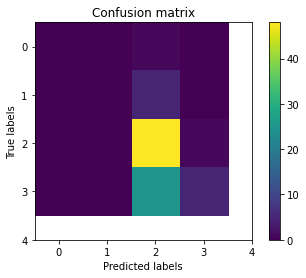

In [397]:
confusion_mat = confusion_matrix(DT_label_test,classifier.predict(DT_features_test))
confusion = pd.crosstab(DT_label_test,classifier.predict(DT_features_test))


# Visualize confusion matrix
plt.imshow(confusion_mat, interpolation='nearest')
plt.title('Confusion matrix')
plt.colorbar()
ticks = np.arange(5)
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()